# Histopathologic Cancer Detection

**Challenge Problem:**

This is a binary image classification challenge. Our task is to develop a model that can determine whether a small and centered region within a larger histopathologic scan contains metastatic cancer.

**Data Description:**

The data consists of medical images in .tif files, where each image is 96x96 pixels with three color channels. Each image in the training set has a binary label. A label of 1 indicates that the central 32x32 region contains metastatic cancer, while a label of 0 indicates the the region does not.

## **Data Loading and Initial Exploration**

In this section, we will load the training and test data, and explore the basic characteristics of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [2]:
# Data Paths
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

In [3]:
# Basic Data Information
print("Number of training labels:", len(train_labels))
print("First 5 rows of train_labels:")
print(train_labels.head())
print("Number of training images:", len(os.listdir(train_dir)))
print("Number of test images:", len(os.listdir(test_dir)))

Number of training labels: 220025
First 5 rows of train_labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Number of training images: 220025
Number of test images: 57458


We have loaded the training and test data and printed the number of training labels, the first 5 rows of training labels, the number of training images, and the number of test images. This gives us a basic understanding of the dataset's size and structure.

## **Data Visualization**
In this section, we will visualize the data to understand the distribution of labels and the characteristics of the images.

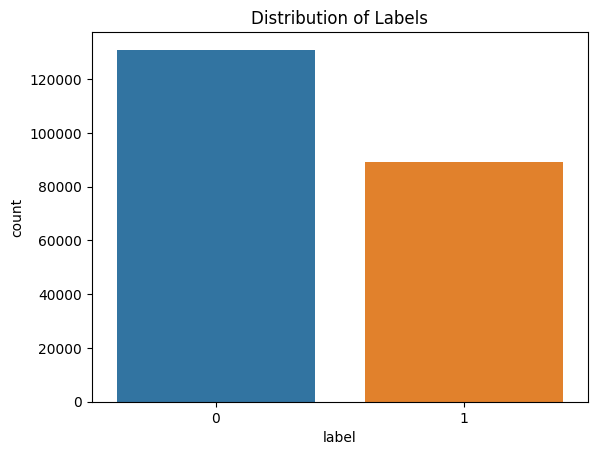

In [4]:
# Label Distribution
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels')
plt.show()

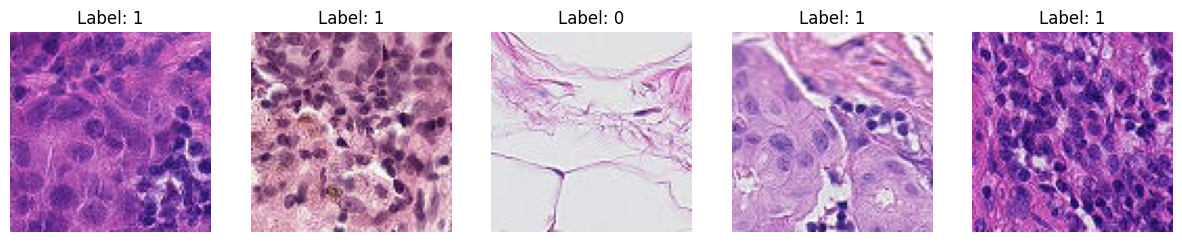

In [5]:
# Sample Images
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img_path = os.path.join(train_dir, images[i] + '.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    
sample_images = train_labels.sample(5)
display_images(sample_images['id'].values, sample_images['label'].values)

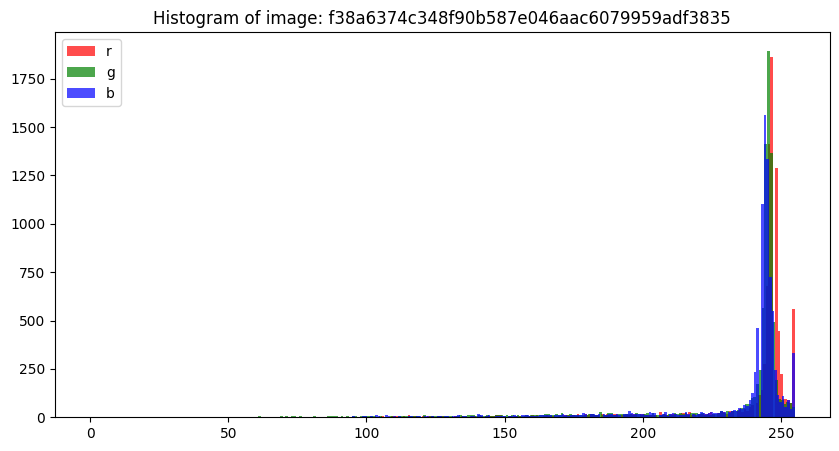

In [6]:
# Image Histograms
def plot_image_histograms(image_id):
    image_path = os.path.join(train_dir, image_id +'.tif')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,5))
    for i,color in enumerate(['r','g','b']):
        plt.hist(image[:,:,i].flatten(), bins=256, color=color, alpha=0.7, label=color)
    plt.legend()
    plt.title(f"Histogram of image: {image_id}")
    plt.show()
plot_image_histograms(train_labels['id'].values[0])

In [7]:
# Checking for missing images (takes way too long)
#missing_images = []
#for image_id in train_labels['id']:
#    if not os.path.exists(os.path.join(train_dir, image_id + '.tif')):
#        missing_images.append(image_id)
#print("Number of missing images:", len(missing_images))

# Output is Number of missing images: 0

We have visualized the distribution of labels, displayed sample images, and plotted image histograms. These visualizations help us understand the data's characteristics and potential challenges, such as class imbalance.

## **Data Preprocessing and Sampling**
In this section, we will preprocess the data and sample a smaller dataset for faster training (for demonstration purposes).

In [8]:
# Sample a Smaller Dataset for Faster Training
n = 30000

all_0s = train_labels[train_labels['label'] == 0]
all_1s = train_labels[train_labels['label'] == 1]

sample_0s = all_0s.sample(n)
sample_1s = all_1s.sample(n)

balanced_subset = pd.concat([sample_0s, sample_1s], axis=0).sample(frac=1).reset_index(drop=True)

print("Sampled Training DataFrame:")
print(balanced_subset.head())

Sampled Training DataFrame:
                                         id  label
0  54e5971f3e9ae1047f8738d90089e2e5fe8cc302      0
1  6e7c99726b159ee5d4ad975277dd5cf059964187      0
2  9bcd683b32bcf386e441f1b602ccf8ec389b260f      0
3  e881eede41a0fef80742296726e214909dfacf47      0
4  4dd245c4606d458669477cc773ebdf1adfbc6300      1


In [9]:
# Load Images
def load_image(image_id, image_dir):
    image_path = os.path.join(image_dir, image_id +'.tif')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [10]:
# Create Training Data (X) and Labels (y)
X = np.array([load_image(i, train_dir) for i in balanced_subset['id']])
y = balanced_subset['label'].values

We have sampled a smaller dataset to reduce training time. We have also defined functions to load and preprocess the images and created the training data (X) and labels (y).

## **Model Architecture**
In this section, we will define the model architectures.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Rescaling, Cropping2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define Models
def create_model(lr):
        model = Sequential([
        Input((96, 96, 3)),
        Rescaling(1./255),
        
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer=l2(0.001)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['AUC'])
        return model
    
def create_model_deeper(lr):
        model = Sequential([
        Input((96, 96, 3)),
        Rescaling(1./255),
        
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer=l2(0.001)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['AUC'])
        return model

In [12]:
# Instantiate Models
model_simple_slr = create_model(0.00025)
model_simple_llr = create_model(0.0025)
model_deeper_slr = create_model_deeper(0.00025)
model_deeper_llr = create_model_deeper(0.0025)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We have defined two model architectures: a simple model and a deeper model. We have also instantiated these models with different learning rates.

## **Model Training and Hyperparameter Tuning**
In this section, we will train the models and discuss the hyperparameter tuning process.

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, verbose=1, min_lr=1e-6, mode='max')
early_stop = EarlyStopping(monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)

In [14]:
# Train Models
history1 = model_simple_slr.fit(X, y, validation_split=0.2, epochs=10, callbacks=[reduce_lr,early_stop])
history2 = model_simple_llr.fit(X, y, validation_split=0.2, epochs=10, callbacks=[reduce_lr,early_stop])
history3 = model_deeper_slr.fit(X, y, validation_split=0.2, epochs=10, callbacks=[reduce_lr,early_stop])
history4 = model_deeper_llr.fit(X, y, validation_split=0.2, epochs=10, callbacks=[reduce_lr,early_stop])

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - AUC: 0.7565 - loss: 0.6132 - val_AUC: 0.8641 - val_loss: 0.5107 - learning_rate: 2.5000e-04
Epoch 2/10
  25/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.8435 - loss: 0.5441 

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8368 - loss: 0.5316 - val_AUC: 0.8758 - val_loss: 0.4654 - learning_rate: 2.5000e-04
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8500 - loss: 0.5088 - val_AUC: 0.8808 - val_loss: 0.4604 - learning_rate: 2.5000e-04
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8623 - loss: 0.4886 - val_AUC: 0.8901 - val_loss: 0.4577 - learning_rate: 2.5000e-04
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8714 - loss: 0.4742 - val_AUC: 0.8944 - val_loss: 0.4290 - learning_rate: 2.5000e-04
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8854 - loss: 0.4521 - val_AUC: 0.8908 - val_loss: 0.4364 - learning_rate: 2.5000e-04
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8966 - loss: 0.4304 - val_AUC: 0.9005 - val_loss: 0.4440 - learning_rate: 2.5000e-04
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.9096 - loss: 0.4046 - val_AUC: 0.9019 - val_loss: 0.4

**Discussion: Model Training and Hyperparameter Tuning**
We trained four models all based on the architecture metnioned in class: a simple model with a small learning rate (model_simple_slr), a simple model with a large learning rate (model_simple_llr), a bigger model with a small learning rate (model_deeper_slr), and a bigger model with a large learning rate (model_deeper_llr).

**Hyperparameter Tuning:**
- **Learning Rate:** We explored two learning rates: 0.00025 (small) and 0.0025 (large). The smaller learning rate (0.00025) generally yielded better results, indicating that a more conservative update of the model's weights was beneficial. The larger learning rate (0.0025) led to poor convergence.
- **Model Architecture:** We compared a simple architecture with fewer layers and a bigger architecture with more layers. The smaller architecture, when trained with the smaller learning rate, performed better, suggesting that there was no need to have additional capacity to learn more complex features from the images.

**Results Analysis:**
- **model_simple_slr:** Had the best performance, indicating that the simple model with a small learning rate captures the relevant patterns.
- **model_simple_llr:** Resulted in a validation AUC close to 0.5. This highlights the importance of choosing an appropriate learning rate.
- **model_deeper_slr:** Showed the second best performance, demonstrating that a deeper model with a small learning rate can also effectively learn from the data.
- **model_deeper_llr:** Similar to the simple model with a large learning rate, this model also resulted in a validation AUC close to 0.5.

## **Test Prediction and Submission**
In this section, we will make predictions on the test data and create a submission file.

In [15]:
# Prepare Test Data
test_id_list = [f.split('.')[0] for f in os.listdir(test_dir)]
X_te = np.array([load_image(i, image_dir=test_dir) for i in test_id_list])

In [16]:
# Predictions
results = model_simple_slr.predict(X_te)
results = results.reshape(-1)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [17]:
# Create Submission DataFrame
results_df = pd.DataFrame({
    'id': test_id_list,
    'label': results.tolist(),
})

In [18]:
# Save Submission File
results_df.to_csv('submission.csv', index=False)

In [19]:
# Display First Few Rows of Submission
results_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.734744
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.112479
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.310368
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.765053
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.436120


We have loaded the test data, made predictions using the trained model, and created a submission file.

Score: 0.8355

## **Conclusion**

**Discussion and Interpretation of Results:**

In this notebook, we explored the Histopathologic Cancer Detection challenge, aiming to build a model capable of accurately classifying histopathologic scans. We experimented with different model architectures and learning rates, observing that a simpler model with a smaller learning rate achieved the best performance.

**Learnings and Takeaways:**
- Learning Rate Sensitivity: The learning rate significantly impacts model convergence. A small learning rate allowed for stable training and better performance, while a large learning rate led to poor convergence.
- Model Architecture Impact: Surprisingly, a simpler model architecture, when trained with an appropriate learning rate, demonstrated superior performance in this case. This suggests that deeper models are not always better, and that simpler models can be more effective for certain datasets.
- Regularization and Callbacks: Techniques like L2 regularization, early stopping, and learning rate reduction helped improve training stability and prevent overfitting.

**What Did and Did Not Help:**
- Helped: A simpler model architecture and a small learning rate helped improve performance. Regularization and callbacks also played a crucial role.
- Did Not Help: A larger learning rate and a deeper model architecture hindered performance in this case.

**Future Improvements:**
- Data Augmentation: Implement data augmentation techniques to increase the robustness of the model and improve generalization.
- Transfer Learning: Explore transfer learning using pre-trained models like ResNet or EfficientNet to leverage pre-trained features.
- Hyperparameter Tuning: Conduct a more extensive hyperparameter tuning on other parameters.
- Class Imbalance Handling: Explore techniques to address class imbalance, such as oversampling or undersampling.
- More epochs: train for more epochs.
- Explore simpler models more: Explore simpler models, and see if there are other simpler architectures that could perform even better.
- Explore different regularization techniques: Explore L1, or dropout regularization, and see if they improve performance.

Github Repo:

https://github.com/MFranco2000/miniature-octo-memory/blob/main/notebook079c680ad4.ipynb